# Milestone 2 : How To Make a Hit Movie

Team members: ZHOU Xiao, LIU Jiafan

Abstract: Today, movies are basically the most popular type of art and entertainment for us. People go to the cinema to watch a movie or buy it on Amazon, and give reviews and ratings on it. But for movie makers, movies are a type of business. Some blockbusters like "Avatar" have earned billions of dollars, while a lot of other movies are not as lucky as the highest-grossing ones. So we may wonder how to make a hit movie. We will try to use data analysis to answer this question. From the matadata, reviews, ratings and even subtitles of movies, we would like to find factors and features that make a movie to become best seller on Amazon or take high revenues from the box office.

In [2]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import re
import scipy as sp
import json
import requests
import warnings
sns.set_context('notebook')
warnings.filterwarnings('ignore')
import gzip

# 1. Data Loading and Preprocessing

# 1.1)  Amazon Data Loading and Preprocessing

In this notebook, we uses three data files from [Amazon review dataset](http://jmcauley.ucsd.edu/data/amazon/links.html): `meta_Movies_and_TV.json.gz`, `ratings_Movies_and_TV.csv` and `reviews_Movies_and_TV_5.json.gz`, which contain 5-core subset of the Amazon reviews and ratings on `Movies & TV` category, and also the metadata of all `Movies & TV` products.

 | dataset | size | contents |
 | ------- | ---- | -------- |
 |`meta_Movies_and_TV.json.gz`|95.2MB (258MB after decompression)|asin, title, price, imUrl, related, salesRank, brand, categories|
 |`ratings_Movies_and_TV.csv`|178MB|reviewerID, asin, overall, unixReviewTime|
 |`reviews_Movies_and_TV_5.json.gz`| 676MB (1.84GB after decompression)| reviewerID, asin, reviewerName, helpful, reviewText, overall, summary, unixReviewTime, reviewTime|



First we define the functions to read json datasets. The datasets are not in strict json but we can use `eval()` to parse it and load it into pandas dataframes.

In [2]:
# functions to parse and read json.gz datasets

def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

### Load reviews dataset to dataframes

In [4]:
# load reviews
reviews_raw = getDF('data/reviews_Movies_and_TV_5.json.gz')
reviews_raw.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,ADZPIG9QOCDG5,0005019281,"Alice L. Larson ""alice-loves-books""","[0, 0]",This is a charming version of the classic Dick...,4.0,good version of a classic,1203984000,"02 26, 2008"
1,A35947ZP82G7JH,0005019281,Amarah Strack,"[0, 0]",It was good but not as emotionally moving as t...,3.0,Good but not as moving,1388361600,"12 30, 2013"
2,A3UORV8A9D5L2E,0005019281,Amazon Customer,"[0, 0]","Don't get me wrong, Winkler is a wonderful cha...",3.0,Winkler's Performance was ok at best!,1388361600,"12 30, 2013"
3,A1VKW06X1O2X7V,0005019281,"Amazon Customer ""Softmill""","[0, 0]",Henry Winkler is very good in this twist on th...,5.0,It's an enjoyable twist on the classic story,1202860800,"02 13, 2008"
4,A3R27T4HADWFFJ,0005019281,BABE,"[0, 0]",This is one of the best Scrooge movies out. H...,4.0,Best Scrooge yet,1387670400,"12 22, 2013"


### Load matedata to dataframes

First we import the datasets and then we do some cleaning and exploration.

In [5]:
# load metadata
meta_raw = getDF('data/meta_Movies_and_TV.json.gz')
meta_raw.head()

,asin,categories,description,title,price,salesRank,imUrl,related,brand
0,0000143561,"[[Movies & TV, Movies]]","3Pack DVD set - Italian Classics, Parties and ...","Everyday Italian (with Giada de Laurentiis), V...",12.99,{'Movies & TV': 376041},http://g-ecx.images-amazon.com/images/G/01/x-s...,"{'also_viewed': ['B0036FO6SI', 'B000KL8ODE', '...",NaN
1,0000589012,"[[Movies & TV, Movies]]",NaN,Why Don't They Just Quit? DVD Roundtable Discu...,15.95,{'Movies & TV': 1084845},http://ecx.images-amazon.com/images/I/519%2B1k...,"{'also_bought': ['B000Z3N1HQ', '0578045427', '...",NaN
2,0000695009,"[[Movies & TV, Movies]]",NaN,Understanding Seizures and Epilepsy DVD,NaN,{'Movies & TV': 1022732},http://g-ecx.images-amazon.com/images/G/01/x-s...,NaN,NaN
3,000107461X,"[[Movies & TV, Movies]]",NaN,Live in Houston [VHS],NaN,{'Movies & TV': 954116},http://ecx.images-amazon.com/images/I/41WY47gL...,NaN,NaN
4,0000143529,"[[Movies & TV, Movies]]",Disc 1: Flour Power (Scones; Shortcakes; South...,My Fair Pastry (Good Eats Vol. 9),19.99,{'Movies & TV': 463562},http://ecx.images-amazon.com/images/I/51QY79CD...,"{'also_bought': ['B000NR4CRM', 'B0019BK3KQ', '...",NaN


### Remove useless and redundant information

We can drop some columns which we don't need. We don't need 'description', 'imUrl' and 'brand'.

In [12]:
# remove redundant data
metadata = meta_raw.drop(['description','imUrl', 'brand'], axis=1)
metadata.head()

,asin,categories,title,price,salesRank,related
0,0000143561,"[[Movies & TV, Movies]]","Everyday Italian (with Giada de Laurentiis), V...",12.99,{'Movies & TV': 376041},"{'also_viewed': ['B0036FO6SI', 'B000KL8ODE', '..."
1,0000589012,"[[Movies & TV, Movies]]",Why Don't They Just Quit? DVD Roundtable Discu...,15.95,{'Movies & TV': 1084845},"{'also_bought': ['B000Z3N1HQ', '0578045427', '..."
2,0000695009,"[[Movies & TV, Movies]]",Understanding Seizures and Epilepsy DVD,NaN,{'Movies & TV': 1022732},NaN
3,000107461X,"[[Movies & TV, Movies]]",Live in Houston [VHS],NaN,{'Movies & TV': 954116},NaN
4,0000143529,"[[Movies & TV, Movies]]",My Fair Pastry (Good Eats Vol. 9),19.99,{'Movies & TV': 463562},"{'also_bought': ['B000NR4CRM', 'B0019BK3KQ', '..."


In [26]:
# check the categories
metadata['categories'].value_counts().head()

[[Movies & TV, Movies]]                                                                  138383
[[Movies & TV, TV]]                                                                       53327
[[Movies & TV]]                                                                            1251
[[CDs & Vinyl, Classical], [CDs & Vinyl, Opera & Classical Vocal], [Movies & TV, TV]]       767
[[CDs & Vinyl, Classical], [Movies & TV, TV]]                                               630
Name: categories, dtype: int64

Since we only want to analyse the movie entries, we extract only the items with `categories` which contains 'Movies' rather than 'TV'.

In [50]:
# check if the lists in categories contain 'Movie'
def check_movie(categories):
    for lst in categories:
        if 'Movies' in lst:
            return True
    return False

non_movie_idx = []
for idx, categories in enumerate(metadata['categories']):
    if not check_movie(categories):
        non_movie_idx.append(idx)

In [53]:
# drop non-movie rows
metadata = metadata.drop(metadata.index[non_movie_idx])
metadata['categories'].value_counts().head()

[[Movies & TV, Movies]]                                                                                                         138383
[[Movies & TV, Movies], [Movies & TV, TV]]                                                                                         582
[[Movies & TV, Movies], [Pet Supplies, Dogs, Training & Behavior Aids]]                                                             25
[[Movies & TV, Movies], [Musical Instruments, Studio Recording Equipment, Mastering Recorders, DVD Recorders & Duplicators]]        22
[[Movies & TV, Movies], [Musical Instruments, Instrument Accessories, General Accessories]]                                         19
Name: categories, dtype: int64

In [54]:
metadata.shape

(139209, 6)

Up to now we get 139209 entries of movies.

We set the row indices to be the movie id `asin`, so that we can find a movie by `asin` in an easier way.

In [60]:
# set proper indices
metadata = metadata.set_index(['asin'])

In [61]:
metadata.head()

,categories,title,price,salesRank,related
asin,,,,,
0000143561,"[[Movies & TV, Movies]]","Everyday Italian (with Giada de Laurentiis), V...",12.99,{'Movies & TV': 376041},"{'also_viewed': ['B0036FO6SI', 'B000KL8ODE', '..."
0000589012,"[[Movies & TV, Movies]]",Why Don't They Just Quit? DVD Roundtable Discu...,15.95,{'Movies & TV': 1084845},"{'also_bought': ['B000Z3N1HQ', '0578045427', '..."
0000695009,"[[Movies & TV, Movies]]",Understanding Seizures and Epilepsy DVD,NaN,{'Movies & TV': 1022732},NaN
000107461X,"[[Movies & TV, Movies]]",Live in Houston [VHS],NaN,{'Movies & TV': 954116},NaN
0000143529,"[[Movies & TV, Movies]]",My Fair Pastry (Good Eats Vol. 9),19.99,{'Movies & TV': 463562},"{'also_bought': ['B000NR4CRM', 'B0019BK3KQ', '..."


### Check the NaN values

In [55]:
# check if there are NaNs
metadata.count()

asin          139209
categories    139209
title          72426
price          97614
salesRank     137063
related        98799
dtype: int64

In [56]:
metadata['title'].isna().sum()

66783

In [57]:
metadata['price'].isna().sum()

41595

In [58]:
metadata['salesRank'].isna().sum()

2146

In [59]:
metadata['related'].isna().sum()

40410

We find that the data is not that clean. All the columns besides `asin` and `categories` have NaN values. We should take care of the NaNs in the following analysis.

Since `salesRank` is an important feature for our future analysis, we would like to drop NaN values in `salesRank`. Besides, we find that not all `salesRank` are in `Movies & TV` category. After these cleanings, we transform the dictionary format in `salesRank` to be integers.

In [19]:
# remove NaN in salesRank
metadata = metadata[pd.notnull(metadata['salesRank'])]

### Clean non-movie sales rank

We find those entries whose salesRank is not in 'Movies' category.

In [21]:
# find ranks that are not in 'Movies' categery
non_movie_rank_idx = []

for idx, entry in enumerate(metadata['salesRank']):
    try:
        entry['Movies & TV']
    except:
        print(entry)
        non_movie_rank_idx.append(idx)

{'Books': 3777257}
{'Sports &amp; Outdoors': 196802}
{'Sports &amp; Outdoors': 313153}
{'Sports &amp; Outdoors': 270719}
{'Sports &amp; Outdoors': 88095}
{'Sports &amp; Outdoors': 48980}
{'Home &amp; Kitchen': 1875215}
{'Sports &amp; Outdoors': 161238}
{'Sports &amp; Outdoors': 187816}
{'Sports &amp; Outdoors': 198792}
{'Sports &amp; Outdoors': 279376}
{'Sports &amp; Outdoors': 139174}
{'Sports &amp; Outdoors': 22081}
{'Sports &amp; Outdoors': 74027}
{'Sports &amp; Outdoors': 159306}
{'Home &amp; Kitchen': 500388}
{'Sports &amp; Outdoors': 172992}
{'Sports &amp; Outdoors': 2368645}
{'Sports &amp; Outdoors': 93635}
{'Sports &amp; Outdoors': 284007}
{'Books': 12403985}
{'Sports &amp; Outdoors': 86344}
{'Sports &amp; Outdoors': 1137788}
{'Sports &amp; Outdoors': 98032}
{'Sports &amp; Outdoors': 205446}
{'Sports &amp; Outdoors': 75059}
{'Books': 4643699}
{'Sports &amp; Outdoors': 113644}
{'Sports &amp; Outdoors': 1103171}
{'Sports &amp; Outdoors': 133101}
{'Sports &amp; Outdoors': 94600}
{

In [24]:
# remove useless ranks and change the rank dictionary into integers
metadata = metadata.drop(metadata.index[non_movie_rank_idx])
metadata['salesRank'] = metadata['salesRank'].apply(lambda entry: entry['Movies & TV'])
metadata.head()

,categories,title,price,salesRank,related
asin,,,,,
0000143561,"[[Movies & TV, Movies]]","Everyday Italian (with Giada de Laurentiis), V...",12.99,376041,"{'also_viewed': ['B0036FO6SI', 'B000KL8ODE', '..."
0000589012,"[[Movies & TV, Movies]]",Why Don't They Just Quit? DVD Roundtable Discu...,15.95,1084845,"{'also_bought': ['B000Z3N1HQ', '0578045427', '..."
0000695009,"[[Movies & TV, Movies]]",Understanding Seizures and Epilepsy DVD,NaN,1022732,NaN
000107461X,"[[Movies & TV, Movies]]",Live in Houston [VHS],NaN,954116,NaN
0000143529,"[[Movies & TV, Movies]]",My Fair Pastry (Good Eats Vol. 9),19.99,463562,"{'also_bought': ['B000NR4CRM', 'B0019BK3KQ', '..."


In [45]:
metadata.shape

(136999, 5)

Thousands of useless data has been removed.

### Import ratings data

Now we begin to deal with the ratings data. The ratings data is a subset of reviews data, while it doesn't contain review texts thus has a smaller size. So it is easier for we to first analyze only the ratings.

In [58]:
# import ratings, set column names
ratings = pd.read_csv('ratings_Movies_and_TV.csv', header=None)
ratings = ratings.rename(columns = {0:'reviewerID', 1:'asin', 2:'overall', 3:'unixReviewTime'})
ratings.head()

,reviewerID,asin,overall,unixReviewTime
0,A3R5OBKS7OM2IR,0000143502,5.0,1358380800
1,A3R5OBKS7OM2IR,0000143529,5.0,1380672000
2,AH3QC2PC1VTGP,0000143561,2.0,1216252800
3,A3LKP6WPMP9UKX,0000143588,5.0,1236902400
4,AVIY68KEPQ5ZD,0000143588,5.0,1232236800


### Check NaN values

First we check if there are NaN values in the ratings data.

In [59]:
ratings.shape

(4607047, 4)

In [60]:
# check NaNs
ratings.count()

reviewerID        4607047
asin              4607047
overall           4607047
unixReviewTime    4607047
dtype: int64

So we get the good news. Now we transform the unix timestamp 'unixReviewTime' to readable datetime format.

### Transform time format

In [62]:
# transform unix review time to data time
ratings['unixReviewTime'] = pd.to_datetime(ratings['unixReviewTime'], unit='s')
ratings = ratings.rename(columns={'unixReviewTime': 'time'})
ratings.head()

,reviewerID,asin,overall,time
0,A3R5OBKS7OM2IR,0000143502,5.0,2013-01-17
1,A3R5OBKS7OM2IR,0000143529,5.0,2013-10-02
2,AH3QC2PC1VTGP,0000143561,2.0,2008-07-17
3,A3LKP6WPMP9UKX,0000143588,5.0,2009-03-13
4,AVIY68KEPQ5ZD,0000143588,5.0,2009-01-18


### Clean non-movie ratings

Again, we don't want useless ratings for TV. We drop the non-movie entries, i.e. those don't appear in our metadata.

In [63]:
# find non-movie ratings
non_movie_idx = []
for idx, asin in enumerate(ratings['asin']):
    if not asin in metadata.index:
        non_movie_idx.append(idx)

In [65]:
# clean non-movie ratings
ratings = ratings.drop(ratings.index[non_movie_idx])
ratings.shape

(3061065, 4)

So over 1 million useless ratings have been removed.

In [43]:
ratings['overall'].value_counts()

5.0    1699346
4.0     615578
3.0     310711
1.0     259068
2.0     176362
Name: overall, dtype: int64

We can find that the fequency of ratings are actually like 5>4>3>1>2.

# 1.2) TMDB Data Loading and Preprocessing

Load the TMDB credits data and TMDB movies data into pandas dataframes.

In [6]:
tmdb_credits_raw= pd.read_csv('data/tmdb_5000_credits.csv')
tmdb_movies_raw=pd.read_csv('data/tmdb_5000_movies.csv')

show the TMDB credits dataframe

In [7]:
tmdb_credits_raw.head()

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


We can see the columns contained in credits dataframe, and the special index for a single film is movie_id. It contains cast and crew information.

Also, we show the dataframe of TMDB movies

In [8]:
tmdb_movies_raw.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


The dataframe also has a id column, corresponding to movie_id in previous one, and we can see there are many more information, which can process further analysis.

We merge the 2 dataframes and correspond each movie in one dataframe to the other, since they both have id features. After that,we show the columns of merged dataframe.

In [9]:
tmdb_credits_raw = tmdb_credits_raw.rename(columns= {'movie_id': 'id'})
tmdb_data_raw = pd.merge(tmdb_credits_raw, tmdb_movies_raw,on='id')
tmdb_data_raw.columns

Index(['id', 'title_x', 'cast', 'crew', 'budget', 'genres', 'homepage',
       'keywords', 'original_language', 'original_title', 'overview',
       'popularity', 'production_companies', 'production_countries',
       'release_date', 'revenue', 'runtime', 'spoken_languages', 'status',
       'tagline', 'title_y', 'vote_average', 'vote_count'],
      dtype='object')

We can see the features that the dataframe contains and we can implement data analysis upon that.

In [10]:
tmdb_data = tmdb_data_raw.rename(columns= {'title_x': 'title'})

First, we can see that in some columns, the information is contained in an unnormal structure, like json. Our first step is to recognise the columns and split the data structure to distill only the useful information.

In [11]:
import json
tmdb_json_columns = ['spoken_languages','genres', 'keywords', 'production_companies', 'production_countries', 'cast','crew']
for column in tmdb_json_columns:
    tmdb_data[column] = tmdb_data[column].apply(json.loads)
def splitName(column):
    temp_col = [[temp_row['name'] for temp_row in rows] for rows in column]
    return temp_col
tmdb_split_columns = ['spoken_languages','genres', 'keywords', 'production_companies', 'production_countries', 'cast']
for column in tmdb_split_columns:
    tmdb_data[column] = splitName(tmdb_data[column])

Now we can see the columns have been turned into a list, as we show in the preprocessed preocution_countries column. It will help us a lot in further data analysis.

In [12]:
tmdb_data['production_countries'].head()

0    [United States of America, United Kingdom]
1                    [United States of America]
2    [United Kingdom, United States of America]
3                    [United States of America]
4                    [United States of America]
Name: production_countries, dtype: object

There is an exception, the crew column. There are plenty of jobs and plenty of information of that, so we can not just use use the method above to get only the names. We shall also correspond the name to their jobs.

In order to get the specific job in a crew feature, we define the function below to get the name from the specific job.

In [14]:
def getName(temp_row,job):
    temp_name=''
    for i in range(len(temp_row)):
        if temp_row[i]['job'] == job:
            temp_name = temp_row[i]['name']
            break 
    return temp_name

Here we get the name of main director and append it to the dataframe. It will help us to get the job information of a movie and it's much more convenient to implement analysis.

In [15]:
tmdb_data['director'] = [getName(temp_row,'Director') for temp_row in tmdb_data['crew']]
tmdb_data[['director']].head()

,director
0,James Cameron
1,Gore Verbinski
2,Sam Mendes
3,Christopher Nolan
4,Andrew Stanton


Also, we only take the year information of release_date.

In [16]:
tmdb_data['release_year'] = pd.to_datetime(tmdb_data['release_date']).dt.year
tmdb_data['release_year'].describe()

count    4802.000000
mean     2002.468763
std        12.414354
min      1916.000000
25%      1999.000000
50%      2005.000000
75%      2011.000000
max      2017.000000
Name: release_year, dtype: float64

Our topic is about how to make a hit movie, the goal of which is to explore how to make a movie as profitable as possible. 

In [17]:
tmdb_data['profit'] = (tmdb_data['revenue'] - tmdb_data['budget']) / tmdb_data['budget']
tmdb_data[['profit']].head()

,profit
0,10.763566
1,2.203333
2,2.594590
3,3.339756
4,0.092843


We can manually create a feature that judges whether the title of a movie has channged or not, determined by original_title and titile.

In [18]:
if_title_change= tmdb_data['original_title']==tmdb_data['title']
def judge_change(not_change):
    change=0
    if not_change: change=1
    return change
tmdb_data['title_change']= [judge_change(not_change) for not_change in if_title_change]

Also among the cast, we have to get the main actors or actresses since there are too many cast in one movie. The huge amount of vice actors and actresses will not bring a huge influence to a movie. So we only get the top 5 cast in a movie, which represents for the top main characters in a movie.

In [19]:
tmdb_data['cast']=[temp_cast[:5] for temp_cast in tmdb_data['cast']]

Now we show the columns after preprocessin of dataframe.

In [20]:
tmdb_data.columns

Index(['id', 'title', 'cast', 'crew', 'budget', 'genres', 'homepage',
       'keywords', 'original_language', 'original_title', 'overview',
       'popularity', 'production_companies', 'production_countries',
       'release_date', 'revenue', 'runtime', 'spoken_languages', 'status',
       'tagline', 'title_y', 'vote_average', 'vote_count', 'director',
       'release_year', 'profit', 'title_change'],
      dtype='object')

To implement our topic and approach,we will use corresponding features to analyze what features make a hit movie. We manually drop the columns that will not take a casual effect of a hit movie and clean the dataframe.

In [21]:
temp_drop_col=['crew','original_title','overview','id','homepage','status','tagline','title_y','release_date']
tmdb_data = tmdb_data.drop(temp_drop_col, axis=1)

Here we finish doing simple data wrangling and the preprocessed TMDB dataframe is what we want for future analysis.

In [22]:
tmdb_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4803 entries, 0 to 4802
Data columns (total 18 columns):
title                   4803 non-null object
cast                    4803 non-null object
budget                  4803 non-null int64
genres                  4803 non-null object
keywords                4803 non-null object
original_language       4803 non-null object
popularity              4803 non-null float64
production_companies    4803 non-null object
production_countries    4803 non-null object
revenue                 4803 non-null int64
runtime                 4801 non-null float64
spoken_languages        4803 non-null object
vote_average            4803 non-null float64
vote_count              4803 non-null int64
director                4803 non-null object
release_year            4802 non-null float64
profit                  3913 non-null float64
title_change            4803 non-null int64
dtypes: float64(5), int64(4), object(9)
memory usage: 712.9+ KB


# 1.3) Merging Amazon Data and TMDB Data

Above we finish the sepeate prepreocessing of amazon data and TMDB data. Our final goal is to use the all informative features to analyze how to make a hit movie. In this section, we merge the data for further deep analysis, which will be implemented until Milestone 3.

In [29]:
merge_raw=pd.merge(tmdb_data, metadata,on='title')
merge_raw=pd.merge(merge_raw, reviews_raw,on='asin')
merge_raw.head()

,title,cast,budget,genres,keywords,original_language,popularity,production_companies,production_countries,revenue,...,price,related,reviewerID,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,Tangled,"[Zachary Levi, Mandy Moore, Donna Murphy, Ron ...",260000000,"[Animation, Family]","[hostage, magic, horse, fairy tale, musical, p...",en,48.681969,"[Walt Disney Pictures, Walt Disney Animation S...",[United States of America],591794936,...,29.98,NaN,A2JJ0KQTN8QED3,Bap8494,"[4, 4]",I can't understand why I haven't heard more ab...,5.0,Shocking!!,1332115200,"03 19, 2012"
1,Tangled,"[Zachary Levi, Mandy Moore, Donna Murphy, Ron ...",260000000,"[Animation, Family]","[hostage, magic, horse, fairy tale, musical, p...",en,48.681969,"[Walt Disney Pictures, Walt Disney Animation S...",[United States of America],591794936,...,29.98,NaN,A35Z5BLHL9CI8P,"Charlene ""divercity@interia.pl""","[2, 4]","It's definitely a must-see. Very climatic, mys...",5.0,"Great acting, great plot, great movie",1125360000,"08 30, 2005"
2,Tangled,"[Zachary Levi, Mandy Moore, Donna Murphy, Ron ...",260000000,"[Animation, Family]","[hostage, magic, horse, fairy tale, musical, p...",en,48.681969,"[Walt Disney Pictures, Walt Disney Animation S...",[United States of America],591794936,...,29.98,NaN,A19RAJY6R7USN0,"Lee Neville ""emotionboy""","[4, 6]",Rachael Leigh Cook stars and looks amazing in ...,2.0,Tangled movie,1048809600,"03 28, 2003"
3,Tangled,"[Zachary Levi, Mandy Moore, Donna Murphy, Ron ...",260000000,"[Animation, Family]","[hostage, magic, horse, fairy tale, musical, p...",en,48.681969,"[Walt Disney Pictures, Walt Disney Animation S...",[United States of America],591794936,...,29.98,NaN,A3R36DZQEWNVJ1,Mike Bolts,"[2, 5]","Shawn Hatosy (The Faculty, Outside Providence)...",1.0,Tangled gets tangled in its own self......a bi...,1130630400,"10 30, 2005"
4,Tangled,"[Zachary Levi, Mandy Moore, Donna Murphy, Ron ...",260000000,"[Animation, Family]","[hostage, magic, horse, fairy tale, musical, p...",en,48.681969,"[Walt Disney Pictures, Walt Disney Animation S...",[United States of America],591794936,...,29.98,NaN,A29Q1SCC4OCO67,mypetconcubine,"[14, 15]",Tangled is a smart and edgy thriller with a ta...,4.0,Love Triangle Thriller,1114473600,"04 26, 2005"


We merge the dataframe due to the shared name of movie while 2 amazon datasets are merged by asin feature speified in amazon database.

In [30]:
merge_raw.columns

Index(['title', 'cast', 'budget', 'genres', 'keywords', 'original_language',
       'popularity', 'production_companies', 'production_countries', 'revenue',
       'runtime', 'spoken_languages', 'vote_average', 'vote_count', 'director',
       'release_year', 'profit', 'title_change', 'asin', 'categories', 'price',
       'related', 'reviewerID', 'reviewerName', 'helpful', 'reviewText',
       'overall', 'summary', 'unixReviewTime', 'reviewTime'],
      dtype='object')

We can get the informative feature columns for the final merged dataframe, and we will implement detailed analysis upon them.

# 1.4) Generate pickle file

We save the preprocessed dataframe to a generated pickle file, which is more efficient for later data analysis.

In [25]:
tmdb_data.to_pickle('tmdb_data.pkl')
merge_raw.to_pickle('merge_raw.pkl')
reviews_raw.to_pickle('reviews_raw')
metadata.to_pickle('metadata.pkl')
ratings.to_pickle('ratings.pkl')

In [3]:
tmdb_data = pd.read_pickle('tmdb_data.pkl')
merge_raw = pd.read_pickle('merge_raw.pkl')
reviews_raw = pd.read_pickle('reviews_raw')
metadata = pd.read_pickle('metadata.pkl')
ratings = pd.read_pickle('ratings.pkl')

# 2. Amazon Descriptive Statistical Analysis

# 2.1) Analysis on metadata

### Analyze the correlation between price and sales rank

Now we would like to do a simple analysis on the correlation between `price` and `salesRank`. First we should drop NaN values on price or salesRank.

In [47]:
# drop NaNs in price
price_sale = metadata[['price', 'salesRank']].dropna()
price_sale.head()

,price,salesRank
asin,,
0000143561,12.99,376041
0000589012,15.95,1084845
0000143529,19.99,463562
0000143502,62.51,467172
0000143588,9.15,309405


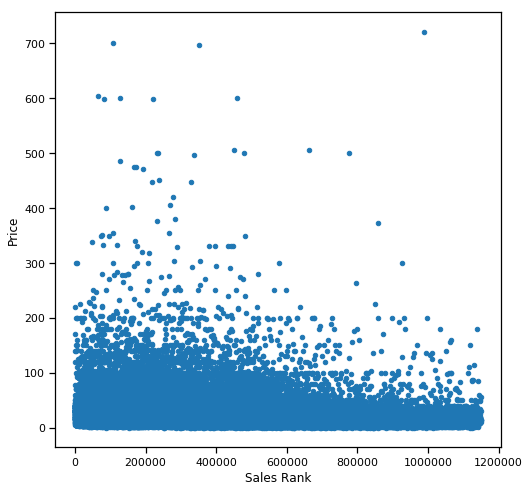

In [162]:
# the scatter plot of price and sales rank
ax = price_sale.plot.scatter(x='salesRank', y='price', figsize=(8, 8))
ax.set_xlabel('Sales Rank')
ax.set_ylabel('Price')
plt.savefig('rank-price.png')

In [89]:
# Pearson coefficient
r, p = sp.stats.pearsonr(price_sale['price'], price_sale['salesRank'])
print("Pearson's correlation coefficient: " + str(r) + "\n2-tailed p-value: " + str(p))

Pearson's correlation coefficient: -0.10131897529225159
2-tailed p-value: 1.6617704686971954e-219


There are too many points in the plot but there seems to be a negative relation between price and sales rank. From the Pearson correlation coefficient we notice a very weak negative correlation between the two factors. Now we'd like to divide the sales rank into intervals of length 100000 and see how the average price and median price change over rank intervals.

In [164]:
# divide rank intervals as [0,100000), [100000, 200000), ...
price_sale['rankInterval'] = price_sale['salesRank'].apply(lambda rank: int(rank)//100000*100000)
price_sale.head()

,price,salesRank,rankInterval
asin,,,
0000143561,12.99,376041,300000
0000589012,15.95,1084845,1000000
0000143529,19.99,463562,400000
0000143502,62.51,467172,400000
0000143588,9.15,309405,300000


In [173]:
# group by rank interval
price_rankinterval = price_sale[['price', 'rankInterval']].groupby(['rankInterval'])
interval_average_price = price_rankinterval.mean()
interval_median_price = price_rankinterval.median()

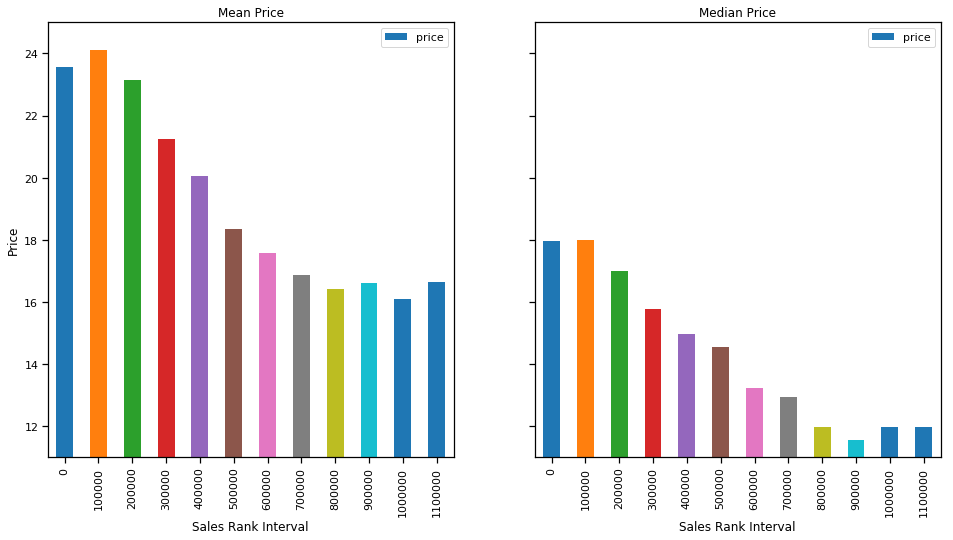

In [181]:
# plot mean price and median price of each rank interval
fig, axs = plt.subplots(1, 2, sharey=True)
interval_average_price.plot(y='price', kind='bar', title='Mean Price', ax=axs[0], ylim=[11, 25], figsize=(16, 8))
interval_median_price.plot(y='price', kind='bar', title='Median Price', ax=axs[1])
axs[0].set_xlabel('Sales Rank Interval')
axs[0].set_ylabel('Price')
axs[1].set_xlabel('Sales Rank Interval')
plt.savefig('rankinterval-price.png')

So we can observe the prices for higher-ranked movies are higher in general. This partly proves that pricey products are likely to be valuable and cheap products may not be of good quality.

### Analyze the distribution of prices

Now we are curious about the distribution of prices, so we do some simple analysis on prices.

In [51]:
# statistical description of price
price_sale['price'].describe()

count    96930.000000
mean        21.498796
std         22.979707
min          0.010000
25%          9.660000
50%         15.280000
75%         24.990000
max        719.960000
Name: price, dtype: float64

The mean is about 21.5 dollars and the median is about 15.3 dollars. The max amount 720 dollars is definitely an outlier, and those outliers with high prices lift up the mean.

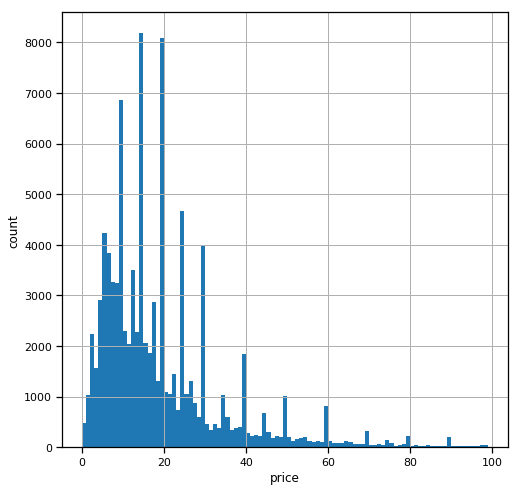

In [53]:
# plot the histogram of price distribution in intervals of length 1
plt.xlabel('price')
plt.ylabel('count')
ax = price_sale['price'].hist(bins=range(0,100), figsize=(8, 8))

We get some interesting results. When we divide the price axis to intervals of length 1, we find that the price count is not smoothly changing with growing price.

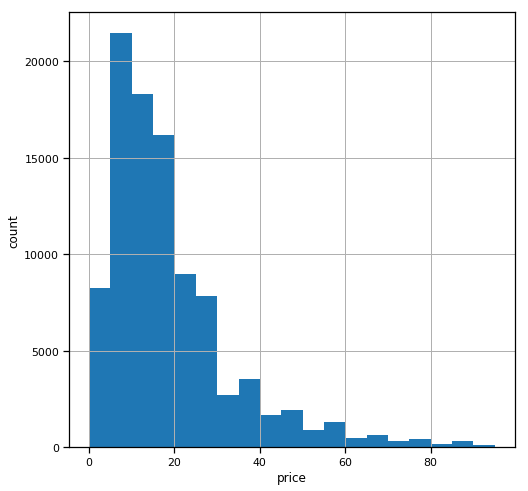

In [55]:
# plot the histogram of price distribution in intervals of length 5
plt.xlabel('price')
plt.ylabel('count')
ax = price_sale['price'].hist(bins=range(0,100,5),figsize=(8, 8))

If we divide the price axis to intervals of length 5, the histogram seems to be more smooth. We could find that Amazon have special preference on some specific price numbers:

In [35]:
# count most frequent prices
price_count = price_sale['price'].value_counts()
price_count.head(20)

14.98    2671
19.99    2326
19.98    2075
19.95    2068
14.99    1834
9.99     1767
24.95    1705
14.95    1498
2.99     1494
29.95    1434
9.98     1433
24.98    1149
29.99    1010
24.99     929
9.95      846
29.98     733
5.98      716
17.99     708
6.99      691
5.00      687
Name: price, dtype: int64

As we can see, Amazon doesn't like integers - they sell at 14.98 rather than 15, and sell at 19.99 rather than 20. This is a common known selling trick. Besides, the price numbers are likely to be close to a multiple of 5.

# 2.2) Analysis on ratings

### Group ratings by movies

We group the ratings by the same movie(same `asin`) so we can analyse ratings for a specific movie.

In [68]:
# groupby movie
movie_ratings = ratings.groupby(['asin'])

In [69]:
# get average rating on each movie
movie_mean_ratings = movie_ratings.mean()
movie_mean_ratings.head()

,overall
asin,
0000143502,5.000000
0000143529,5.000000
0000143561,2.000000
0000143588,5.000000
0000589012,4.103448


In [70]:
movie_mean_ratings.shape

(131860, 1)

We get the mean ratings for 131860 movies, less than 136999 movies in total. So there may be some movies with too few ratings so they are not in the 5-core dataset. Now we merge the movie average ratings with metadata.

In [126]:
# merge ratings with ranks for further analysis
rating_rank_merge = pd.merge(movie_mean_ratings, metadata, on='asin')[['overall', 'salesRank']]
rating_rank_merge.head()

,overall,salesRank
asin,,
0000143502,5.000000,467172
0000143529,5.000000,463562
0000143561,2.000000,376041
0000143588,5.000000,309405
0000589012,4.103448,1084845


We would like to analyze the correlation between overall average ratings and sales rank.

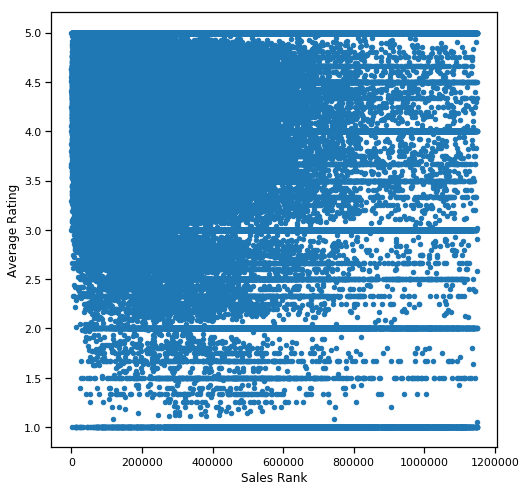

In [170]:
# plot scatter of sales rank and mean rating
ax = rating_rank_merge.plot.scatter(x='salesRank', y='overall',figsize=(8, 8))
ax.set_xlabel('Sales Rank')
ax.set_ylabel('Average Rating')
plt.savefig('rank-rating.png')

In [128]:
# Pearson Coefficient
r, p = sp.stats.pearsonr(rating_rank_merge['salesRank'], rating_rank_merge['overall'])
print("Pearson's correlation coefficient: " + str(r) + "\n2-tailed p-value: " + str(p))

Pearson's correlation coefficient: -0.07527765387414483
2-tailed p-value: 5.624678085001144e-165


Since the amount of data is huge, it is hard for us to find a pattern from the scatter plot. Besides, the correlation coefficient shows a very weak negative correlation.

Same as before, now we consider dividing salesRank to several intervals and see if the plot will be easy to read. We divide the salesRank to intervals of length 100000, 12 intervals in total.

In [130]:
# divide rank intervals as [0,100000), [100000, 200000), ...
rating_rank_merge['rankInterval'] = rating_rank_merge['salesRank'].apply(lambda rank: int(rank)//100000*100000)
rating_rank_merge.head()

,overall,salesRank,rankInterval
asin,,,
0000143502,5.000000,467172,400000
0000143529,5.000000,463562,400000
0000143561,2.000000,376041,300000
0000143588,5.000000,309405,300000
0000589012,4.103448,1084845,1000000


We use the mean of each movie's average ratings as the average rating for the rank interval.

In [176]:
# group by rank interval
rating_rankinterval_merge = rating_rank_merge[['overall', 'rankInterval']].groupby(['rankInterval'])
interval_average_rating = rating_rankinterval_merge.mean()
interval_median_rating = rating_rankinterval_merge.median()

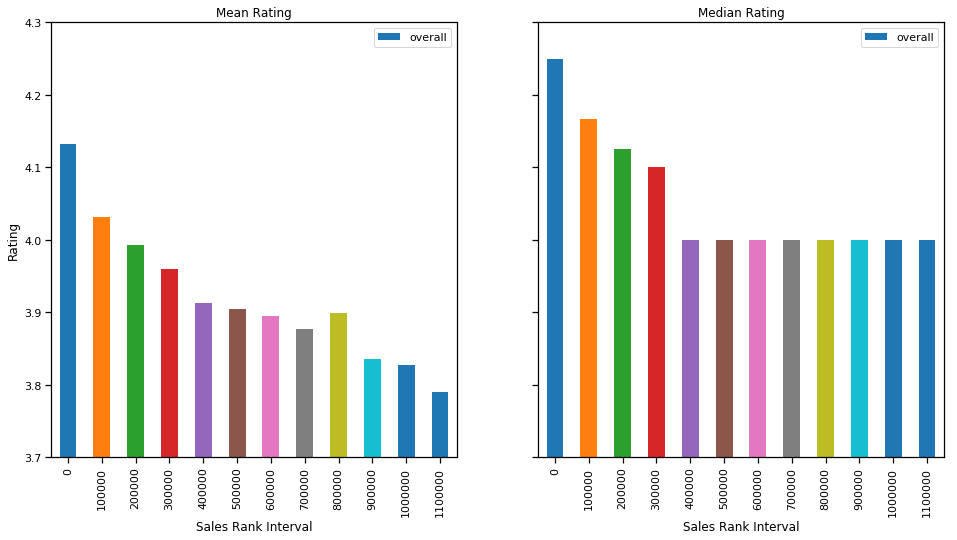

In [180]:
# plot mean price and median rating of each rank interval
fig, axs = plt.subplots(1, 2, sharey=True)
interval_average_rating.plot(y='overall', kind='bar', title='Mean Rating', ax=axs[0], ylim=[3.7, 4.3], figsize=(16, 8))
interval_median_rating.plot(y='overall', kind='bar', title='Median Rating', ax=axs[1])
axs[0].set_xlabel('Sales Rank Interval')
axs[0].set_ylabel('Rating')
axs[1].set_xlabel('Sales Rank Interval')
plt.savefig('rankinterval-rating.png')

As we can see, there is a decrese in the average and median rating as sales rank interval grows. This matches our instinct that best sellers will receive higher ratings, and that movies with a high reputation tend to sell better.

### Group ratings by time

Now we consider group ratings by time so we can analyze the trend of ratings over time.

In [79]:
# group ratings by time
time_ratings = ratings.groupby(['time'])

In [80]:
# average rating on each day
time_mean_ratings = time_ratings.mean()
time_mean_ratings.head()

,overall
time,
1997-08-09,4.0
1997-08-19,1.0
1997-08-23,5.0
1997-09-14,5.0
1997-09-20,5.0


In [78]:
# statistical description on rating time
ratings['time'].describe()

count                 3061065
unique                   5981
top       2014-03-25 00:00:00
freq                     5834
first     1997-08-09 00:00:00
last      2014-07-23 00:00:00
Name: time, dtype: object

In [81]:
time_mean_ratings.shape

(5981, 1)

Now we would like to pick a certain movie and see how its ratings change over time. Is there any trend for a hit movie? First we extract movies which rank top 100 in 'Moives and TV' in our dataset.

In [184]:
# extract top 100 in rank
top100_movies = price_sale[price_sale['salesRank']<=100]
top100_movies

,price,salesRank,rankInterval
asin,,,
B0083SBMGW,219.00,12,0
B00G5G7EXY,29.99,51,0
B00GQQ77IU,39.99,38,0
B00GQQ75QO,29.95,83,0
B00K2CHVSK,44.95,84,0
B00L4K3MLE,39.99,71,0


So we would like choose the first one - B0083SBMGW which ranks 12th in 'Movies & TV'.

In [203]:
# select ratings on B0083SBMGW and sort by time
bestseller_ratings = ratings[ratings['asin']=='B0083SBMGW'].sort_values('time')
bestseller_ratings.head()

,reviewerID,asin,overall,time
4095110,ALLVXWH9HCW2X,B0083SBMGW,5.0,2012-05-18
4095488,A1V6Q88B7KNSSU,B0083SBMGW,2.0,2012-06-01
4095554,A1TUOBR9DYKZJA,B0083SBMGW,3.0,2012-06-01
4095192,A3VSJG6D62P1HU,B0083SBMGW,5.0,2012-06-01
4095060,A2CKFK43Z4CTPF,B0083SBMGW,5.0,2012-06-05


We'd like to group monthly ratings to see a clear trend.

In [214]:
# get month from given date
bestseller_ratings['month'] = bestseller_ratings['time'].dt.to_period('M')
bestseller_ratings.head()

,reviewerID,asin,overall,time,month
4095110,ALLVXWH9HCW2X,B0083SBMGW,5.0,2012-05-18,2012-05
4095488,A1V6Q88B7KNSSU,B0083SBMGW,2.0,2012-06-01,2012-06
4095554,A1TUOBR9DYKZJA,B0083SBMGW,3.0,2012-06-01,2012-06
4095192,A3VSJG6D62P1HU,B0083SBMGW,5.0,2012-06-01,2012-06
4095060,A2CKFK43Z4CTPF,B0083SBMGW,5.0,2012-06-05,2012-06


In [217]:
# group monthly ratings
bestseller_monthly_rating = bestseller_ratings[['overall', 'month']].groupby(['month'])
bestseller_monthly_average_rating = bestseller_monthly_rating.mean()

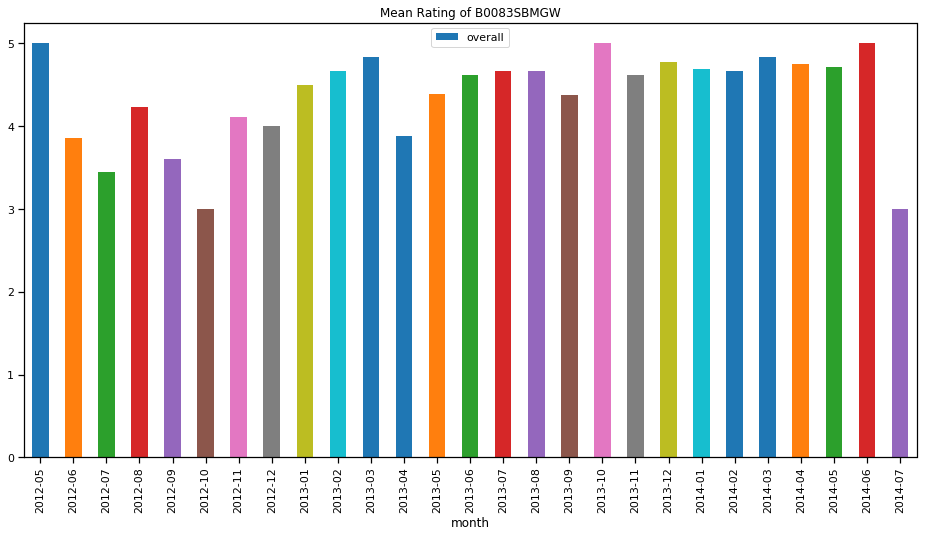

In [225]:
# plot monthly ratings trend
bestseller_monthly_average_rating.plot(y='overall', kind='bar', title='Mean Rating of B0083SBMGW', figsize=(16, 8))
plt.savefig('monthly-rating.png')

There is not an increasing or decreasing trend in the monthly rating. However, we can observe that the average rating has unstable rise and fall in the first few months, and turns out to be stable gradually.

### Group ratings by reviewers

After grouping the ratings by movies, we can think about grouping ratings by reviewers. Different reviewer has a different average rating, so it is meaningful for us to do a normalization to assign different weights on different reviewers' ratings in our later work, which will lead to a more reasonable weighted average rating.

In [75]:
# groupby reviewers
reviewer_ratings = ratings.groupby(['reviewerID'])

In [76]:
# get each reviewer's mean rating
reviewer_mean_ratings = reviewer_ratings.mean()
reviewer_mean_ratings.head()

,overall
reviewerID,
A00005181SC9PSCD58LCG,4.5
A0001392IVCRENBEIEYS,1.0
A0002090WKEMAO8KOWKM,5.0
A000222418JVUV9W33GLH,4.5
A00025603PJ3GM9KBM8TU,1.0


In [77]:
reviewer_mean_ratings.shape

(1415339, 1)

So there are 1415339 reviewers in total.

# 3. TMDB Descriptice Statistical Analysis

# 3.1) TMDB Movie Genre Evoluation 

To make a hit movie, in addtion to simple numbers like budget and popularity, other text information is also informative. For example, the genres have a huge influence of movie reviews. In typical years , specific genres of movie tend to lead a fashion.

We get the evoluation plot of all types of movie with time above.

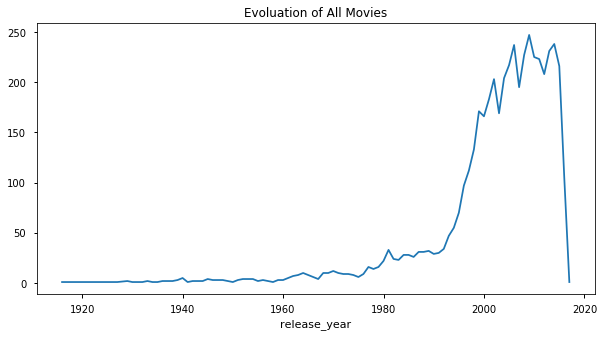

In [26]:
tmdb=tmdb_data.copy()
tmdb_by_year = tmdb.groupby('release_year').size().plot(figsize=(10,5),title='Evoluation of All Movies')

We can see that agter 2000, the number of movies has a explosive increase.

We define a get_count function to get the count of each element in a list feature. The function can be used later not limitted to genres information, but also other preprocessed columns like spoken_launguages and procution_countries.

In [27]:
def get_count(col):
    temp_count = dict()
    for row in col:
        for temp_feature in row:
            if temp_feature in temp_count:
                temp_count[temp_feature] += 1
            else:
                temp_count[temp_feature] = 1
    return temp_count
genres_count = pd.Series(get_count(tmdb['genres'])).sort_values(ascending=False)
genres_count

Drama              2297
Comedy             1722
Thriller           1274
Action             1154
Romance             894
Adventure           790
Crime               696
Science Fiction     535
Horror              519
Family              513
Fantasy             424
Mystery             348
Animation           234
History             197
Music               185
War                 144
Documentary         110
Western              82
Foreign              34
TV Movie              8
dtype: int64

Now we c get the number of each genre of movies with their count number in a descending order.

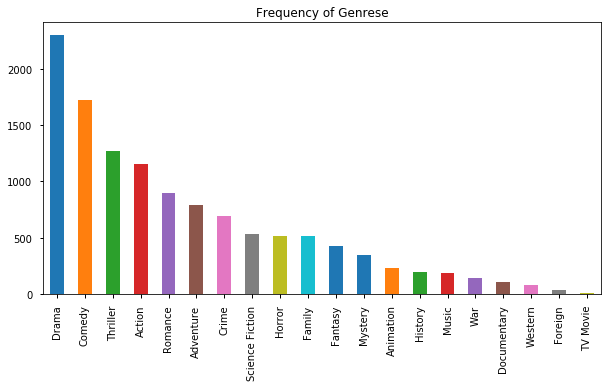

In [28]:
genres_count.plot(kind = 'bar', title = 'Frequency of Genrese',figsize=(10,5))

We get the bar chart of 20 genres of movies with their count number. We can see the Drama account for most.

Then we wish to observe the evoluation of each genre with time. We creae a new dataset with genres as its columns and releasr_year as its index, We can easily get the acount in the genre and get the resulted dataframe.

In [29]:
genres_by_year = tmdb.groupby('release_year').genres.sum()
genres_stat = pd.DataFrame([], index = genres_by_year.index, columns = genres_count.index[0:20])
for temp_year in genres_stat.index:
    for temp_genre in genres_stat.columns:
        genres_stat.loc[temp_year,temp_genre] = genres_by_year[temp_year].count(temp_genre) 
genres_stat.head()

,Drama,Comedy,Thriller,Action,Romance,Adventure,Crime,Science Fiction,Horror,Family,Fantasy,Mystery,Animation,History,Music,War,Documentary,Western,Foreign,TV Movie
release_year,,,,,,,,,,,,,,,,,,,,
1916.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1925.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1927.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1929.0,2,0,1,0,2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1930.0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


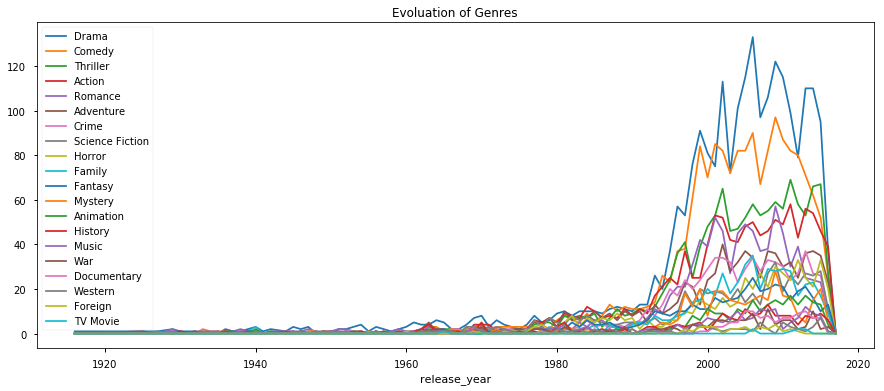

In [30]:
genres_stat.plot(figsize=(15,6),title='Evoluation of Genres')

We plot the evoluation of genres of movies with time. We can see that drama has always been a leading trend in history, followed by comedy. The trend of other genres have been fluctuating through time and market of movies for that are usually changing.

# 3.2) Geographic Distribution

Then we focus on the production countries of movies. Since different countries lead to different cultures and different strengths of countries can lead to different tastes of movies. For example, America is famous for its technology and thus Ameican science fiction movies often take more budget, but they may lead to higher ratings in the other hand. Japan is famous for its worldwide animations and Japanese anaimations often take a large percentage in the market.

In [31]:
country_count = pd.Series(get_count(tmdb['production_countries'])).sort_values(ascending=False)
country_count_df=pd.DataFrame(country_count)
country_count_df['country']=country_count_df.index
country_count_df['count']=country_count_df[0]
country_count_df.reset_index(inplace=True)
country_count_df=country_count_df[['country','count']]
country_count_df.head(10)

,country,count
0,United States of America,3956
1,United Kingdom,636
2,Germany,324
3,France,306
4,Canada,261
5,Australia,110
6,Italy,72
7,Spain,71
8,China,59
9,Japan,58


We use the get_count function again to get the count of each potential countries and get the couts in a descending order.

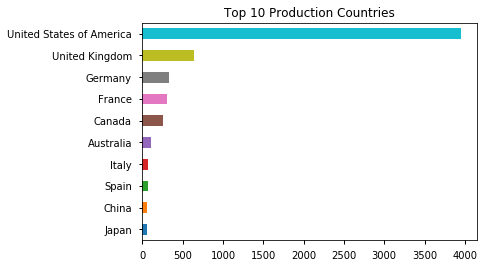

In [63]:
country_count_show=country_count[:10]
country_count_show=country_count_show[::-1]
country_count_show.plot(kind='barh',title='Top 10 Production Countries')

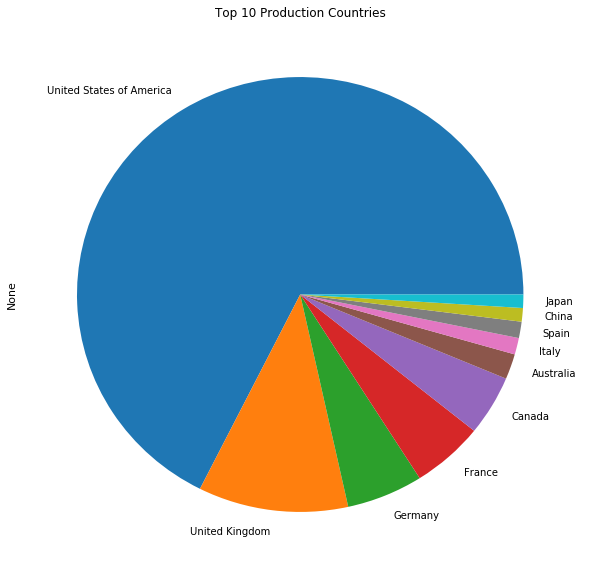

In [64]:
country_count_show_2=country_count[:10]
country_count_show_2.plot(kind='pie',figsize=(10,10),title='Top 10 Production Countries')

Also, we get a horizental bar chart and a pie chart to observe the geographic distribution of movies. We can see in tmdb datasets, there are many more American movies than other countries, followed by United Kindoms and Germany.

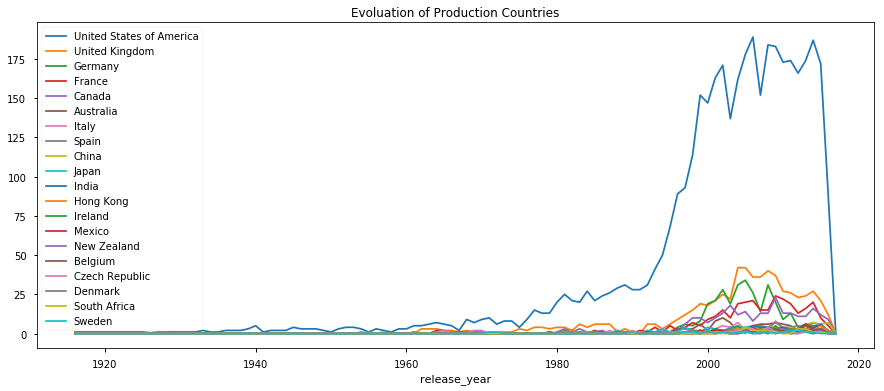

In [34]:
country_by_year = tmdb.groupby('release_year').production_countries.sum()
country_stat = pd.DataFrame([], index = country_by_year.index, columns = country_count.index[0:20])
for temp_year in country_stat.index:
    for temp_country in country_stat.columns:
        country_stat.loc[temp_year,temp_country] = country_by_year[temp_year].count(temp_country) 
country_stat.plot(figsize=(15,6),title='Evoluation of Production Countries')

We plot the evoluation of production countries of movies with time. We can see that America has always been the leading country in movie industry, followed by United Kindom. The trend of other countries have been flucuating through time and market of movies for that are usually changing.But we can observe that the overall trend is that the numbers of all movies a country makes has been in an increase trend in history despite the overall decrease trend in recent years.

Later, we plan to correlate the geographic information with other features in hit movie analysis in section 4 and we plan to utilize folium to show the correlation with other features in the world map, which is more visually readable.

# 3.3) Language and Company Distribution

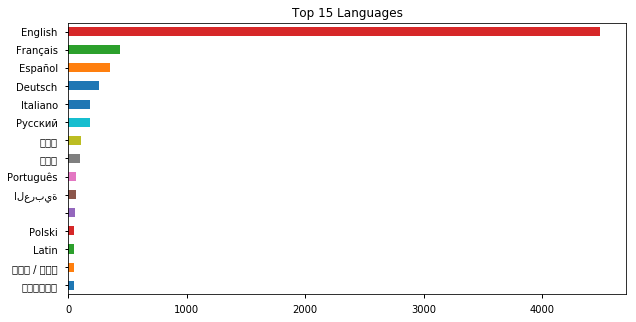

In [35]:
language_count = pd.Series(get_count(tmdb['spoken_languages'])).sort_values(ascending=False)
language_count_show=language_count[:15]
language_count_show=language_count_show[::-1]
language_count_show.plot(kind='barh',figsize=(10,5),title='Top 15 Languages')

We observe English is the dominant Language in tmdb movies.

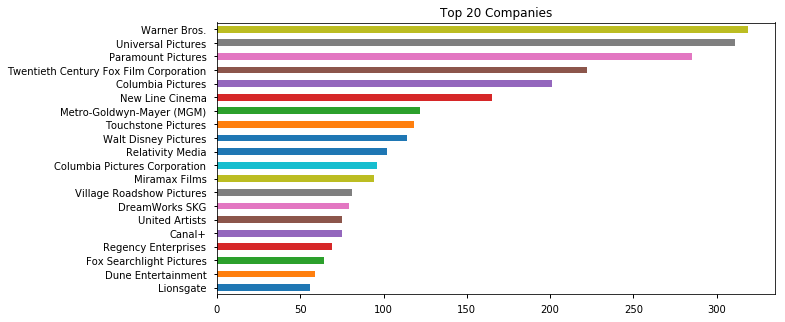

In [36]:
company_count = pd.Series(get_count(tmdb['production_companies'])).sort_values(ascending=False)
company_count_show=company_count[:20]
company_count_show=company_count_show[::-1]
company_count_show.plot(kind='barh',figsize=(10,5),title='Top 20 Companies')

We can get the top popular spoken launguages and production companies as above. In case of contingency, the top mamebers will be utilized in future detailed analysis.

# 3.4) Inflence of Celebrity

Besides genres and production countries, there are some other features that also bring a huge difference to a movie rating, like spoken launguages. In this section,we focus on the influence of celebrity. We wish to oberve whether a famous person who participate in the movie will have an influence on the movie.

Usually there are lots of jobs involved in movie productions, like casts, directors, producer, 3D direrecot and so on. However, the way of getting a cast influence is the same as genres and production countires as above due to the same data strcture of list in dataframe features. So we put our focus on famous people in crew. Since there are too many jobs in crew, we choose directors for analysis since a director can influence the story line and overall prensentation of a movie.

In [37]:
def get_direcotr_count(col):
    temp_count = dict()
    for temp_director in col:
            if temp_director in temp_count:
                temp_count[temp_director] += 1
            else:
                temp_count[temp_director] = 1
    return temp_count

First, we define a function get_director_count to get the dictionary of each director in the dataset and their corresponding count.

In [117]:
director_count = pd.Series(get_direcotr_count(tmdb['director'])).sort_values(ascending=False)
director_count=director_count[1:]
director_count_df=pd.DataFrame(director_count)
director_count_df['director']=director_count_df.index
director_count_df['count']=director_count_df[0]
director_count_df.reset_index(inplace=True)
director_count_df=director_count_df[['director','count']]
director_count_df.head(10)

,director,count
0,Steven Spielberg,27
1,Woody Allen,21
2,Clint Eastwood,20
3,Martin Scorsese,20
4,Robert Rodriguez,16
5,Spike Lee,16
6,Ridley Scott,16
7,Renny Harlin,15
8,Steven Soderbergh,15
9,Oliver Stone,14


We then turn the count into a dataframe in a descending order and show the distribution in a horizontal bar chart.

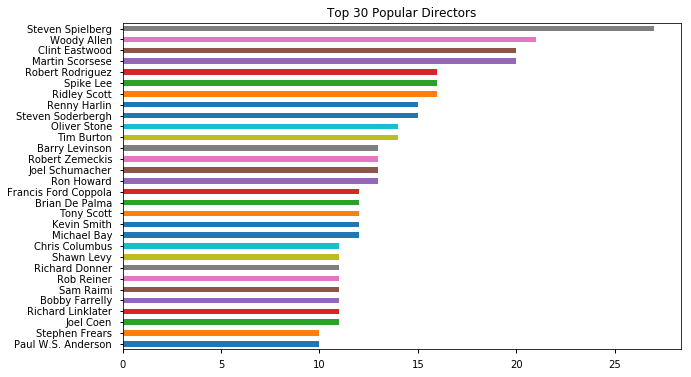

In [118]:
director_count_show=director_count.head(30)
director_count_show=director_count_show[::-1]
director_count_show.plot(figsize=(10,6),kind='barh',title='Top 30 Popular Directors')

The number of movies each director directs is shown above. It shows the popularity of top 30 popular directors.

However, the influence of a director is not only shown by how many movies he/she directs, it's also shown by how many revenue he can bring to a movie, and that's considered as a key part of a hit movie.

We then sum the total revenue of all movies a director directs and show the total_revenue in following dataframe.

In [119]:
director_count_df['total_revenue']=0
for temp_director in director_count_df.director:
    total_tmdb_temp_director=tmdb[tmdb['director']==temp_director]
    temp_total_revenue=total_tmdb_temp_director.revenue.sum()
    temp_index=director_count_df[director_count_df['director']==temp_director].index
    director_count_df.total_revenue[temp_index]=total_tmdb_temp_director.revenue.sum()
director_count_df.head()

,director,count,total_revenue
0,Steven Spielberg,27,9147393164
1,Woody Allen,21,669101038
2,Clint Eastwood,20,2512058888
3,Martin Scorsese,20,1956635998
4,Robert Rodriguez,16,1109899581


We use total_revenue/count to calculate the average revenue a director bring to a movie. Since a director who participates in only  a few movies do not contain much information, we choose the top 20 directors with their average revenue and show the result below with a dataframe and a horizontal chart.

<BarContainer object of 20 artists>

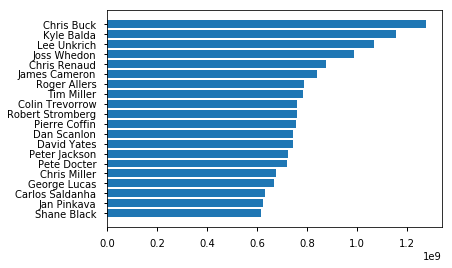

In [121]:
director_df=director_count_df.copy()
director_df['avg_revenue']=director_df['total_revenue']/director_df['count']
director_df=director_df.sort_values(by='avg_revenue',ascending=False)

director_df=director_df.reset_index()
director_df=director_df[['director','avg_revenue']]
director_df=director_df.head(20)
temp_x=director_df['avg_revenue']
temp_x=temp_x[::-1]
temp_y=director_df['director']
temp_y=temp_y[::-1]
plt.barh(temp_y,temp_x)

In this section, we get the number of movies and average revenue of each director and show the result by plots. We will further correlate the information with other feature in machine learning and other approaches in later section in 4. 

# 3.5) Simple Keywords Analysis

Keyword is also an important element that representsn for the theme of a movie and it's worth analyzing in deep text processing domain like natural language preocessing. In the task of descriptive statiscs, we use wordcloud library to show the frequencey of each potential keyword and plot it above.

In [39]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

Here we show the total keywords among all movies in datasets. The keywords plot can be different if we divide movies by genres, countries and directors, but the approach is all the same, we will further correlate the features in merged data in section 4 until milestone 3.

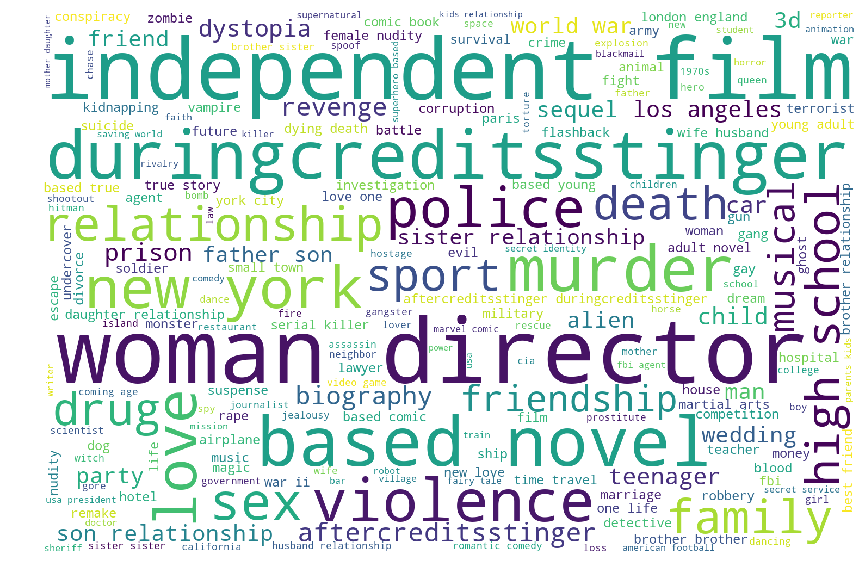

In [40]:
keywords_all= ''
for temp_keywords in tmdb['keywords']:
    for temp_keyword in temp_keywords:
        keywords_all=keywords_all+temp_keyword+' '
    
wc = WordCloud(background_color="white",width=1500, height=1000, margin=2).generate(keywords_all)
plt.figure(figsize=(20, 10))
plt.imshow(wc)
plt.axis('off')
plt.show()

We can also get the top 10 frequent keywords among the movies by a bar chart.

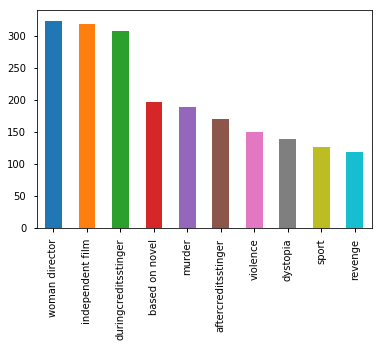

In [41]:
country_count = pd.Series(get_count(tmdb['keywords'])).sort_values(ascending=False)
country_count_show= country_count.head(10)
country_count_show.plot(kind='bar')

# 4. How to Make a Hit Movie

# 4.1) Profit Regression Analysis by Machine Learning

We plan to implement a machine learning analysis inside TMDB data. We wish to analyze the profit as the output for regression. Firstly, we plan to choose the best hyperparameters for the whole training sets by cross validation. Then we plan to use greedy selection to choose the top features that affect the profit the movie by corss vailadation.By machine learning, we can get the top features that have a huge inflence to the movie profit.

Here is a machine learning regression algorithm for profit. We wish to explore the features of a movie instead of just money number like budget and revenue.

We choose the following features as the digit feauures. We choose the profit we get in the preprocessing section as the labels for later regression.

In [65]:
tmdb_ml = tmdb_data.copy()
features=['popularity','runtime','vote_average','vote_count','release_year','title_change']
labels=['profit']
tmdb_features = tmdb_ml[features]
tmdb_labels=tmdb_ml[labels]

We choose genres, countries, directors and spoken language as factors that may affect the profits. Since the text data are stored in list data structure, we can not use simple get_dummy. Thus we use the same approaches in previous sections. 
Also, because features in low-frequency have much contingency, we only choose the top 10 or 20 in these features. For example, a famous director may influence a movie to a large degree, however, the information of those who direct 1 or 2 movie is not informative and can often lead to outliers or noise in machine learning analysis.

In [66]:
for temp_genre in genres_count.index:
    tmdb_features[temp_genre]=0
for temp_genre in genres_count.index:
    for i in range(len(tmdb_features)):
        if temp_genre in tmdb['genres'].values[i]:
            tmdb_features[temp_genre].values[i]=1
            
country_count = pd.Series(get_count(tmdb['production_countries'])).sort_values(ascending=False)
country_count=country_count[:10]
for temp_country in country_count.index:
    tmdb_features[temp_country]=0
for temp_country in country_count.index:
    for i in range(len(tmdb_features)):
        if temp_country in tmdb['production_countries'].values[i]:
            tmdb_features[temp_country].values[i]=1
            
language_count = pd.Series(get_count(tmdb['spoken_languages'])).sort_values(ascending=False)
language_count=language_count[:10]
for temp_language in language_count.index:
    tmdb_features[temp_language]=0
for temp_language in language_count.index:
    for i in range(len(tmdb_features)):
        if temp_language in tmdb['spoken_languages'].values[i]:
            tmdb_features[temp_language].values[i]=1
            
company_count = pd.Series(get_count(tmdb['production_companies'])).sort_values(ascending=False)
company_count=company_count[:10]
for temp_company in company_count.index:
    tmdb_features[temp_company]=0
for temp_language in company_count.index:
    for i in range(len(tmdb_features)):
        if temp_language in tmdb['production_companies'].values[i]:
            tmdb_features[temp_language].values[i]=1
            
director_count = pd.Series(get_direcotr_count(tmdb['director'])).sort_values(ascending=False)
director_count=director_count[:10]
for temp_director in director_count.index:
    tmdb_features[temp_director]=0
for temp_director in director_count.index:
    for i in range(len(tmdb_features)):
        if temp_director in tmdb['director'].values[i]:
            tmdb_features[temp_director].values[i]=1

We get the columns for training features.

In [67]:
tmdb_features.columns

Index(['popularity', 'runtime', 'vote_average', 'vote_count', 'release_year',
       'title_change', 'Drama', 'Comedy', 'Thriller', 'Action', 'Romance',
       'Adventure', 'Crime', 'Science Fiction', 'Horror', 'Family', 'Fantasy',
       'Mystery', 'Animation', 'History', 'Music', 'War', 'Documentary',
       'Western', 'Foreign', 'TV Movie', 'United States of America',
       'United Kingdom', 'Germany', 'France', 'Canada', 'Australia', 'Italy',
       'Spain', 'China', 'Japan', 'English', 'Français', 'Español', 'Deutsch',
       'Italiano', 'Pусский', '普通话', '日本語', 'Português', 'العربية',
       'Warner Bros.', 'Universal Pictures', 'Paramount Pictures',
       'Twentieth Century Fox Film Corporation', 'Columbia Pictures',
       'New Line Cinema', 'Metro-Goldwyn-Mayer (MGM)', 'Touchstone Pictures',
       'Walt Disney Pictures', 'Relativity Media', '', 'Steven Spielberg',
       'Woody Allen', 'Clint Eastwood', 'Martin Scorsese', 'Robert Rodriguez',
       'Spike Lee', 'Ridley Scot

In case of extraordinary features, we again use dropna.

In [80]:
tmdb_features.dropna(how='any')
tmdb_features=tmdb_features.drop('',axis=1)
tmdb_features.head()

,popularity,runtime,vote_average,vote_count,release_year,title_change,Drama,Comedy,Thriller,Action,...,Relativity Media,Steven Spielberg,Woody Allen,Clint Eastwood,Martin Scorsese,Robert Rodriguez,Spike Lee,Ridley Scott,Renny Harlin,Steven Soderbergh
0,3.681033,2.464601,1.104569,11800,0.573645,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,3.347721,2.795984,0.777236,4500,0.381228,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,2.417033,1.801834,0.122572,4466,1.150896,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,2.561928,2.606622,1.541011,9106,0.862271,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
4,0.554537,1.044387,-0.095649,2124,0.862271,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


We split the data into training set and testing set with a ratio of 80% and 20 %. Since we will do randomization in later cross validation process. Here we just take the first 80% of raw dataset to training set.

In [81]:
tmdb_len=len(tmdb_features)
train_features= tmdb_features[:round( 0.8 * tmdb_len )]
test_features = tmdb_features[round( 0.8 * tmdb_len ):]
train_labels= tmdb_labels[:round( 0.8 * tmdb_len )]
test_labels= tmdb_labels[round( 0.8 * tmdb_len ):]

Then we do the normalization. We calculate the mean and std of each column of feature in training set and use the calculated result to realize the normalization in both training and testing datasets.

In [82]:
for temp_col in tmdb_features.columns:
    temp_mean=train_features[temp_col].mean()
    temp_std=train_features[temp_col].std()
    train_features[temp_col]=(train_features[temp_col]-temp_mean)/temp_std
    test_features[temp_col]=(test_features[temp_col]-temp_mean)/temp_std
train_features=train_features.dropna(how='any')
train_features.head()

,popularity,runtime,vote_average,vote_count,release_year,title_change,Drama,Comedy,Thriller,Action,...,Relativity Media,Steven Spielberg,Woody Allen,Clint Eastwood,Martin Scorsese,Robert Rodriguez,Spike Lee,Ridley Scott,Renny Harlin,Steven Soderbergh
0,3.681033,2.464601,1.104569,8.219852,0.573645,0.218427,-0.946139,-0.76517,-0.623223,1.630446,...,-0.165123,-0.084116,-0.068599,-0.072329,-0.066658,-0.062598,-0.055967,-0.064659,-0.062598,-0.05826
1,3.347721,2.795984,0.777236,2.753419,0.381228,0.218427,-0.946139,-0.76517,-0.623223,1.630446,...,-0.165123,-0.084116,-0.068599,-0.072329,-0.066658,-0.062598,-0.055967,-0.064659,-0.062598,-0.05826
2,2.417033,1.801834,0.122572,2.727959,1.150896,0.218427,-0.946139,-0.76517,-0.623223,1.630446,...,-0.165123,-0.084116,-0.068599,-0.072329,-0.066658,-0.062598,-0.055967,-0.064659,-0.062598,-0.05826
3,2.561928,2.606622,1.541011,6.202514,0.862271,0.218427,1.056652,-0.76517,1.604146,1.630446,...,-0.165123,-0.084116,-0.068599,-0.072329,-0.066658,-0.062598,-0.055967,-0.064659,-0.062598,-0.05826
4,0.554537,1.044387,-0.095649,0.974207,0.862271,0.218427,-0.946139,-0.76517,-0.623223,1.630446,...,-0.165123,-0.084116,-0.068599,-0.072329,-0.066658,-0.062598,-0.055967,-0.064659,-0.062598,-0.05826


So far we standardize the values of each feature in the data to have mean 0 and variance 1.

For later manually created cross validation, we prepare it for a function of data split index, build_k_indices. Among the inputs, y is the data we will split in later cross validation, the k_folder is the number we want to divide our dataset with (in the task k_folder is just 5) and seed is random number. We use np.random.seed to randomize the index in input dataset and use k_indices to split the randomized data into k_folder divisions.

In [83]:
def build_k_indices(y, k_fold, seed):
    """build k indices for k-fold."""
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval] for k in range(k_fold)]
    return np.array(k_indices)

In [84]:
n_estimators_range=range(10,110,10)
max_depth_range= range(1,21)
ne_score=pd.DataFrame({'n_estimators':np.array(n_estimators_range),'accuracy':0.0})
mp_score=pd.DataFrame({'max_depth':np.array(max_depth_range),'accuracy':0.0})
rfc_score= pd.merge(ne_score, mp_score)
rfc_score= rfc_score[['n_estimators','max_depth','accuracy']]

Here we get the training features and traing labels for future regression algorithms.

In [94]:
train_features.head()

,popularity,runtime,vote_average,vote_count,release_year,title_change,Drama,Comedy,Thriller,Action,...,Relativity Media,Steven Spielberg,Woody Allen,Clint Eastwood,Martin Scorsese,Robert Rodriguez,Spike Lee,Ridley Scott,Renny Harlin,Steven Soderbergh
0,3.681033,2.464601,1.104569,8.219852,0.573645,0.218427,-0.946139,-0.76517,-0.623223,1.630446,...,-0.165123,-0.084116,-0.068599,-0.072329,-0.066658,-0.062598,-0.055967,-0.064659,-0.062598,-0.05826
1,3.347721,2.795984,0.777236,2.753419,0.381228,0.218427,-0.946139,-0.76517,-0.623223,1.630446,...,-0.165123,-0.084116,-0.068599,-0.072329,-0.066658,-0.062598,-0.055967,-0.064659,-0.062598,-0.05826
2,2.417033,1.801834,0.122572,2.727959,1.150896,0.218427,-0.946139,-0.76517,-0.623223,1.630446,...,-0.165123,-0.084116,-0.068599,-0.072329,-0.066658,-0.062598,-0.055967,-0.064659,-0.062598,-0.05826
3,2.561928,2.606622,1.541011,6.202514,0.862271,0.218427,1.056652,-0.76517,1.604146,1.630446,...,-0.165123,-0.084116,-0.068599,-0.072329,-0.066658,-0.062598,-0.055967,-0.064659,-0.062598,-0.05826
4,0.554537,1.044387,-0.095649,0.974207,0.862271,0.218427,-0.946139,-0.76517,-0.623223,1.630446,...,-0.165123,-0.084116,-0.068599,-0.072329,-0.066658,-0.062598,-0.055967,-0.064659,-0.062598,-0.05826


In [95]:
train_labels.head()

,profit
0,10.763566
1,2.203333
2,2.594590
3,3.339756
4,0.092843


Here we finish the preocessing before implementing the regression algorithms. Since it will take quite a long time, the detailed advanced machine learning algorithm is going to be implemented in future research by milestone 3.

# 4.2) Rating Classification Analysis by Machine Learning

We plan to implement a machine learning analysis in merged data of Amazon rate and TMDB features. We wish to analyze the rate as the output for classification. Firstly, we plan to choose the best hyperparameters for the whole training sets by cross validation. Then we plan to use greedy selection to choose the top features that affect the ratings by corss vailadation.By machine learning, we can get the top features that affect Amazon ratings.

In [100]:
merge_ml=merge_raw.copy()
merge_ml.head(1)

,title,cast,budget,genres,keywords,original_language,popularity,production_companies,production_countries,revenue,...,related,brand,reviewerID,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,Tangled,"[Zachary Levi, Mandy Moore, Donna Murphy, Ron ...",260000000,"[Animation, Family]","[hostage, magic, horse, fairy tale, musical, p...",en,48.681969,"[Walt Disney Pictures, Walt Disney Animation S...",[United States of America],591794936,...,NaN,NaN,A2JJ0KQTN8QED3,Bap8494,"[4, 4]",I can't understand why I haven't heard more ab...,5.0,Shocking!!,1332115200,"03 19, 2012"


We treat it as a classfication problem. Compard with TMDB data, we require new feattures. In this step, we turn the overall values to integral for classification and get the year values of column reviewTime.

In [101]:
merge_ml.overall= [int(temp_overall) for temp_overall in merge_ml.overall]
merge_ml.reviewTime=[int(temp_review_time[-4:]) for temp_review_time in merge_ml.reviewTime]
merge_ml.head(1)

,title,cast,budget,genres,keywords,original_language,popularity,production_companies,production_countries,revenue,...,related,brand,reviewerID,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,Tangled,"[Zachary Levi, Mandy Moore, Donna Murphy, Ron ...",260000000,"[Animation, Family]","[hostage, magic, horse, fairy tale, musical, p...",en,48.681969,"[Walt Disney Pictures, Walt Disney Animation S...",[United States of America],591794936,...,NaN,NaN,A2JJ0KQTN8QED3,Bap8494,"[4, 4]",I can't understand why I haven't heard more ab...,5,Shocking!!,1332115200,2012


We choose the following features as the digit features. Compared with previous regression, we need more features like budget, revenue, reviewTime and prodcution companies. We choose the overall we get as the labels for later classification.

In [102]:
temp_feature=['budget','revenue','budget','popularity','revenue','runtime','vote_average', 'vote_count','release_year','title_change','price',
             'reviewTime']
temp_label=['overall']
merge_features = merge_ml[temp_feature]
merge_labels=merge_ml[temp_label]

Here is the feature columns.

We split the data into training set and testing set with a ratio of 80% and 20 %. Since we will do randomization in later cross validation process. Here we just take the first 80% of raw dataset to training set.In case of extraordinary features, we again use dropna.

In [104]:
merge_features.dropna(how='any')
merge_len=len(merge_features)
train_features= merge_features[:round( 0.8 * merge_len )]
test_features = merge_features[round( 0.8 * merge_len ):]
train_labels= merge_labels[:round( 0.8 * merge_len )]
test_labels= merge_labels[round( 0.8 * merge_len ):]

Then we do the normalization. We calculate the mean and std of each column of feature in training set and use the calculated result to realize the normalization in both training and testing datasets

In [109]:
for temp_col in merge_features.columns:
    temp_mean=train_features[temp_col].mean()
    temp_std=train_features[temp_col].std()
    train_features[temp_col]=(train_features[temp_col]-temp_mean)/temp_std
    test_features[temp_col]=(test_features[temp_col]-temp_mean)/temp_std

In [110]:
n_estimators_range=range(10,110,10)
max_depth_range= range(1,21)
ne_score=pd.DataFrame({'n_estimators':np.array(n_estimators_range),'accuracy':0.0})
mp_score=pd.DataFrame({'max_depth':np.array(max_depth_range),'accuracy':0.0})
rfc_score= pd.merge(ne_score, mp_score)
rfc_score= rfc_score[['n_estimators','max_depth','accuracy']]

Here we get the information of training features and traing labels for future classification algorithms.

In [111]:
train_features.describe()

,budget,revenue,budget,popularity,revenue,runtime,vote_average,vote_count,release_year,title_change,price,reviewTime
count,8.879000e+04,8.879000e+04,8.879000e+04,8.879000e+04,8.879000e+04,8.879000e+04,8.879000e+04,8.879000e+04,8.879000e+04,8.879000e+04,8.713200e+04,8.879000e+04
mean,-3.952035e-14,4.745998e-15,-3.952035e-14,5.753371e-15,4.745998e-15,-1.541446e-15,1.702531e-14,-1.461830e-14,2.103758e-15,-8.778557e-15,-1.219331e-14,1.468945e-14
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.035097e+00,-7.713658e-01,-1.035097e+00,-1.169159e+00,-7.713658e-01,-5.283016e+00,-4.354399e+00,-6.489207e-01,-9.334502e+00,-6.111775e+00,-1.075138e+00,-2.085451e+00
25%,-6.895592e-01,-6.437692e-01,-6.895592e-01,-7.004010e-01,-6.437692e-01,-7.282897e-01,-6.367761e-01,-5.041590e-01,-3.281739e-01,1.636168e-01,-6.170710e-01,-7.221315e-01
50%,-3.174420e-01,-3.197246e-01,-3.174420e-01,-2.739745e-01,-3.197246e-01,-1.705681e-01,6.027817e-02,-3.102581e-01,1.864734e-01,1.636168e-01,-2.309519e-01,-2.676916e-01
75%,4.267923e-01,2.141163e-01,4.267923e-01,3.768442e-01,2.141163e-01,5.265838e-01,6.411567e-01,5.496636e-02,5.724589e-01,1.636168e-01,2.079288e-01,1.095628e+00
max,5.875651e+00,1.142979e+01,5.875651e+00,4.980601e+00,1.142979e+01,7.544580e+00,2.383792e+00,5.600401e+00,2.116401e+00,1.636168e-01,2.156559e+01,1.550068e+00


In [112]:
train_labels.head()

,overall
0,5
1,5
2,2
3,1
4,4


So far we finish the basic preocessing before implementing the classification algorithms. Since it will take quite a long time due to large amount of data, the detailed advanced machine learning algorithm is going to be implemented in future research by milestone 3. We expect the top subsets of features according to hyperparameter tuning and greedy selection can show information about what features of a movie may affect Amazon ratings most and their interconnection.

# Milestone 2 Conclusion

1) Finish data loading from TMDB Datasets and Amazon Datasets, and implement data wrangling and cleaning according to the characteristics of each dataset(including enrich, filter, transform). Thus we are more aware of the datasets and future implementations in the project

2) Do data preprocessing and merge for each dataset for future potential analysis approaches and save the preprocessed dataframes into a pickle file for futher efficient use

3) Implement necessary descriptive statistics tasks in seperate dataframes and corresponding visualization for potentially informative features for further analysis.

4) Design the machine learning appraoch inside TMDB dataset and merged dataset to implement regression of movie profit and Amazon rating classification, as well as the approaches of hyperparameter tuning and greedy selection for most informative features that affect the movies

5) More aware of the datasets and future implementations in the project and made future plans in the project until milestone 3

# A list of internal milestones up until project milestone 3

1) Complete and optimize the machine learning approaches, utilize greedy selection to select features that affect movies profit and correponding Amazon reviews

2) Implement more text data analysis with text processing approaches

3) Analyze the features at higher level with detailed exploration (For example, will the gender of directors or casts make a difference)

4) Finish data report with exlusive analysis and explanantion

5) (Optional) Analyze OpenSubtitle dataset to explore the influence of subtitles to movies

# References on the Amazon dataset

- R. He, J. McAuley. Modeling the visual evolution of fashion trends with one-class collaborative filtering. WWW, 2016
- J. McAuley, C. Targett, J. Shi, A. van den Hengel. Image-based recommendations on styles and substitutes. SIGIR, 2015